# Theme 5 - Fluid-Rock Interactions and the Sub-Seafloor Biosphere
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

**Objective**: Demonstrate how to download Cabled International District Vent Field 1 Vent Fluid Temperature data from the OOI system using the Machine-to-Machine (M2M) interface, downsample the dataset, and export as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Request Data from OOINet

* **Cabled International District Vent Field 1:** Hydrothermal Vent Fluid Temperature and Resistivity
    * Instrument: RS03INT1-MJ03C-10-TRHPHA301
    * Delivery method: streamed
    * Data stream: trhph_sample
    * Parameter name: vent_fluid_temperaure
    * Time range: 2018-01-01 to 2018-07-01

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for this instrument. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# url = request_data('RS03INT1-MJ03C-10-TRHPHA301', 'streamed', 'trhph_sample',
#                    '2018-01-01T00:00:00.000Z', '2018-07-01T00:00:00.000Z')

# print('url = %s' %url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the url must be surrounded by quotations.

In [5]:
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191113T201110088Z-RS03INT1-MJ03C-10-TRHPHA301-streamed-trhph_sample/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files and removing collocated datasets (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets (such as these cabled datasets), but is also fine for working with smaller datasets.

In [6]:
def get_data(url, vars):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in vars:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in vars:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)

    return df, unit_dict

In [7]:
# specify the vent fluid temperature variable and get the data
variables = ['vent_fluid_temperaure']

TRHPH_data, TRHPH_units = get_data(url, variables)

print(TRHPH_units)

{'vent_fluid_temperaure': ['ºC']}


In [8]:
# make sure the timestamps are in ascending order
TRHPH_data.sort_values(by=['time'], inplace=True)  

# print the first few lines of data
TRHPH_data.head()

,time,vent_fluid_temperaure
0,2018-01-01 00:00:13.804581888,285.737488
1,2018-01-01 00:00:33.798757888,285.721588
2,2018-01-01 00:00:53.784583168,285.489960
3,2018-01-01 00:01:13.749860864,285.658081
4,2018-01-01 00:01:33.750088704,285.442322


## Quick Data Plots
Make a quick plot of vent fluid temperature.

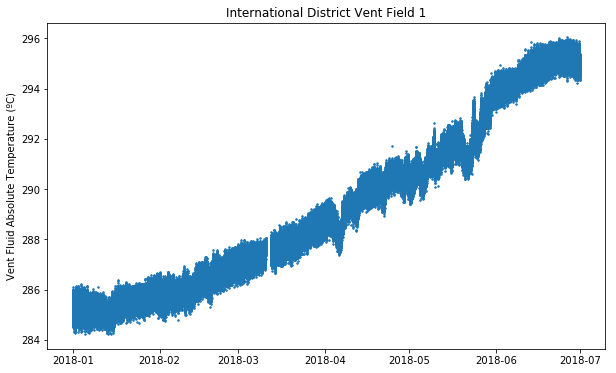

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(TRHPH_data['time'], TRHPH_data['vent_fluid_temperaure'], '.', markersize=3)
ax.set_ylabel('Vent Fluid Absolute Temperature ({})'.format(TRHPH_units['vent_fluid_temperaure'][0]))
ax.set_title('International District Vent Field 1');

In [10]:
# calculate hourly averages to make the dataset more manageable
TRHPH_hourly = TRHPH_data.resample('H', on='time').mean().dropna(how='all').reset_index()
TRHPH_hourly = TRHPH_hourly.rename(columns={'vent_fluid_temperaure': 'Vent Fluid Absolute Temperature (deg_C)'})
TRHPH_hourly.head()

,time,Vent Fluid Absolute Temperature (deg_C)
0,2018-01-01 00:00:00,285.649063
1,2018-01-01 01:00:00,285.588366
2,2018-01-01 02:00:00,285.457522
3,2018-01-01 03:00:00,285.296702
4,2018-01-01 04:00:00,285.132007


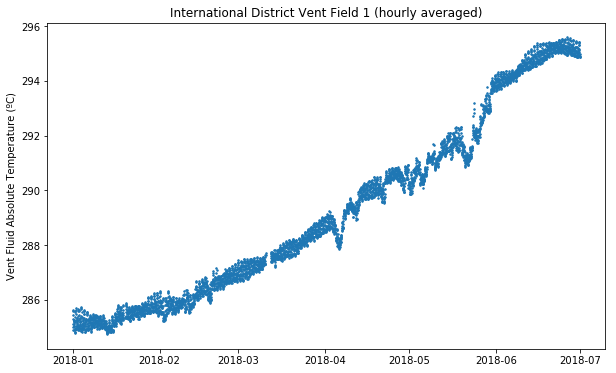

In [11]:
# plot hourly-averaged data
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(TRHPH_hourly['time'], TRHPH_hourly['Vent Fluid Absolute Temperature (deg_C)'], '.', markersize=3)
ax.set_ylabel('Vent Fluid Absolute Temperature ({})'.format(TRHPH_units['vent_fluid_temperaure'][0]))
ax.set_title('International District Vent Field 1 (hourly averaged)');

## 3. Export to csv
Export the hourly-averaged dataset to a .csv file.

In [12]:
TRHPH_hourly.to_csv(os.path.join(save_dir, 'Theme5_INT1_vent_fluid_temps.csv'), index=False)